# RAG Generation Pipeline - LangGraph Workflow Orchestration

**Notebook ID:** `06_generation_v3`  
**Description:** Complete RAG pipeline with query classification, semantic retrieval, and LLM generation using LangGraph

---

## Overview

This notebook implements the **complete RAG (Retrieval-Augmented Generation) pipeline** that powers the chat interface in the production system. It represents a **single-iteration approach** to test whether RAG can retrieve and generate sufficient information in one pass, before implementing more complex self-improving AI agents in version 2.

### Testing Single-Iteration RAG

This version tests whether **one retrieval pass** provides sufficient information for accurate answers. We wanted to validate that:
- Semantic retrieval returns relevant context on the first attempt
- The retrieved chunks contain enough information for comprehensive answers
- Single-iteration responses meet quality standards before adding complexity

### Future: Self-Improving Agents (Version 2)

Before implementing **self-improving AI agents** (planned for version 2), we needed to establish a baseline. Future versions will use:
- **Reflection agents**: Review and critique initial answers
- **ReAct agents**: Iterate over retrieval results until sufficient information is gathered
- **Multi-step reasoning**: Break complex queries into sub-queries and synthesize results

This lightweight workflow serves as the foundation for those more advanced capabilities.

### Safety-First Design

The pipeline implements **comprehensive guardrails** with a safety-first approach:

1. **Query Classification**: Every query is classified for relevance and safety before processing
2. **Irrelevant Query Handling**: The model refuses to answer questions outside the scope of diabetes guidelines
3. **Risky Query Handling**: The model refuses to answer questions that might be harmful or require personalized medical advice
4. **Explicit Refusals**: Clear, polite messages explain why certain queries cannot be answered

These guardrails ensure the system remains focused on its intended purpose (diabetes clinical guidelines) and avoids providing potentially harmful medical advice.

### Lightweight LangGraph Workflow

The pipeline uses a **streamlined LangGraph workflow** that:
- **Classifies queries** for relevance and safety
- **Routes queries** to appropriate handlers (relevant/not relevant/unsafe)
- **Retrieves context** from ChromaDB vector store using semantic similarity
- **Generates answers** with numbered citations `[1]`, `[2]` referencing sources
- **Streams responses** with status updates and final answers

### Development Process

1. **Gradio Testing**: The pipeline was first tested in Gradio to validate:
   - Query classification accuracy
   - Retrieval quality
   - Answer generation with citations
   - Safety guardrails effectiveness

2. **FastAPI Integration**: After validation, the workflow was integrated into FastAPI (`backend/`) to serve the React frontend

3. **Frontend Integration**: The React frontend displays:
   - Generated answers with inline citations
   - Clickable source links for verification
   - Conversation history with context preservation

### Technical Implementation

The workflow uses **state machines** with typed state dictionaries (`ChatState`) that include:
- `messages`: Conversation history (HumanMessage, AIMessage)
- `retrieved_chunks`: Relevant document chunks from vector search
- `sources`: Formatted source citations with URLs
- `classification`: Query classification result (relevant/not_relevant/unsafe)
- `is_followup`: Boolean indicating if query continues previous conversation

**Graph nodes** implement specific pipeline stages:
- `classify_query`: Uses LLM to classify query relevance and safety
- `route_classifier`: Routes to appropriate handler based on classification
- `generator_node`: Orchestrates retrieval and generation using LangChain agents
- `not_relevant_response`: Handles queries outside scope
- `unsafe_response`: Handles potentially harmful queries

This notebook serves as the **prototype** for the production backend, which uses the same LangGraph workflow structure implemented in `backend/graph_builder.py` and `backend/graph_nodes.py`.

---


In [ ]:
# CELL_ID: 06_generation_v3_imports
# ============================================================================
# IMPORT DEPENDENCIES
# ============================================================================

# %pip install langchain langchain-ollama langgraph pydantic chromadb gradio --quiet

import json
import os
from pathlib import Path
from typing import List, Dict, Any, Optional, Literal, TypedDict, Union, Annotated, Sequence
from enum import Enum

# LangChain imports
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage, AnyMessage, BaseMessage
from langchain.tools import tool, ToolRuntime

# LangGraph imports
from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.types import RetryPolicy
from langgraph.config import get_stream_writer
from langchain.agents.middleware import wrap_tool_call

# LangChain agents (v1 - replaces create_react_agent)
from langchain.agents import create_agent

# Pydantic for structured outputs
from pydantic import BaseModel, Field

# ChromaDB
import chromadb
from chromadb.config import Settings

# Gradio for interface
import gradio as gr

print("✓ Imports loaded successfully")


c:\code\genAI\HealthProject\Diabetes_Knowledge_Management\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports loaded successfully


In [2]:
# CELL_ID: 07_generation_v2_chromadb_reader
# ============================================================================
# CHROMADB READER CLASS (REUSED FROM 06_generation_v1)
# ============================================================================

class ChromaDBReader:
    """
    Handles reading/searching from Chroma DB with Jina embedding function.
    Reused from 06_generation_v1.ipynb.
    """
    
    def __init__(
        self,
        chroma_db_path: str = "./chroma_db",
        collection_name: str = "diabetes_guidelines_v1",
        embedding_function = None
    ):
        self.chroma_db_path = Path(chroma_db_path)
        self.collection_name = collection_name
        self.embedding_function = embedding_function
        self.client = None
        self.collection = None
    
    def initialize(self):
        """Initialize ChromaDB client and collection."""
        if self.client is None:
            self.client = chromadb.PersistentClient(
                path=str(self.chroma_db_path),
                settings=Settings(
                    anonymized_telemetry=False,
                    allow_reset=True
                )
            )
            print(f"✓ ChromaDB client initialized: {self.chroma_db_path}")
        
        try:
            self.collection = self.client.get_collection(name=self.collection_name)
            print(f"✓ Loaded collection: {self.collection_name}")
            print(f"  • Total chunks: {self.collection.count()}")
        except Exception as e:
            if self.embedding_function:
                self.collection = self.client.get_collection(
                    name=self.collection_name,
                    embedding_function=self.embedding_function
                )
                print(f"✓ Loaded collection: {self.collection_name}")
                print(f"  • Total chunks: {self.collection.count()}")
            else:
                raise Exception(f"Collection '{self.collection_name}' not found. Make sure you've run 04_vector_store_v1.ipynb first.")
    
    def _unflatten_metadata(self, flat_metadata: Dict) -> Dict:
        """Unflatten metadata (parse JSON strings back to objects)."""
        unflattened = {}
        for key, value in flat_metadata.items():
            try:
                if isinstance(value, str) and (value.startswith('[') or value.startswith('{')):
                    unflattened[key] = json.loads(value)
                else:
                    unflattened[key] = value
            except:
                unflattened[key] = value
        return unflattened
    
    def search(self, query: str, n_results: int = 5, where: Dict = None, min_similarity: float = 0.4) -> List[Dict]:
        """
        Search the collection with semantic search.
        
        Args:
            query: Search query text
            n_results: Number of results to return
            where: Optional metadata filter
            min_similarity: Minimum relevance score (0-1), default 0.4
            
        Returns:
            List of result dictionaries with content, metadata, and relevance score
            Only chunks with relevance_score >= min_similarity are returned
        """
        if not self.collection:
            self.initialize()
        
        results = self.collection.query(
            query_texts=[query],
            n_results=n_results,
            where=where,
            include=['documents', 'metadatas', 'distances']
        )
        
        # Format results and filter by similarity
        formatted_results = []
        seen_chunk_ids = set()
        
        for i in range(len(results['ids'][0])):
            chunk_id = results['ids'][0][i]
            relevance_score = 1 - results['distances'][0][i]
            
            # Filter by minimum similarity
            if relevance_score < min_similarity:
                continue
            
            # Deduplicate
            if chunk_id in seen_chunk_ids:
                continue
            
            chunk_data = {
                'chunk_id': chunk_id,
                'content': results['documents'][0][i],
                'metadata': self._unflatten_metadata(results['metadatas'][0][i]),
                'relevance_score': relevance_score,
                'distance': results['distances'][0][i]
            }
            formatted_results.append(chunk_data)
            seen_chunk_ids.add(chunk_id)
        
        return formatted_results

print("✓ ChromaDBReader class loaded")


✓ ChromaDBReader class loaded


In [ ]:
# CELL_ID: 07_generation_v2_jina_embedding
# ============================================================================
# JINA EMBEDDING FUNCTION (REUSED FROM 06_generation_v1)
# ============================================================================

import os
import requests
import time
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

class JinaEmbeddingFunction:
    """
    Custom embedding function for ChromaDB using Jina API.
    Reused from 06_generation_v1.ipynb.
    """
    
    def __init__(
        self,
        api_key: str = None,
        model: str = "jina-embeddings-v4",
        task: str = "text-matching",
        api_url: str = "https://api.jina.ai/v1/embeddings",
        batch_size: int = 10,
        max_retries: int = 3
    ):
        self.api_key = api_key or os.getenv("JINA_API_KEY")
        if not self.api_key:
            raise ValueError(
                "JINA_API_KEY environment variable is required. "
                "Set it in your .env file or environment."
            )
        self.model = model
        self.task = task
        self.api_url = api_url
        self.batch_size = batch_size
        self.max_retries = max_retries
        self.headers = {
            'Content-Type': 'application/json',
            'Authorization': f'Bearer {self.api_key}'
        }
    
    def name(self) -> str:
        return "jina-embeddings-v4"
    
    def __call__(self, input):
        """Generate embeddings for input text(s)."""
        if isinstance(input, str):
            texts = [input]
        else:
            texts = input
        
        if not texts:
            return []
        
        all_embeddings = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i + self.batch_size]
            batch_embeddings = self._embed_batch(batch)
            all_embeddings.extend(batch_embeddings)
        
        return all_embeddings
    
    def _embed_batch(self, texts: List[str]) -> List[List[float]]:
        """Embed a batch of texts using Jina API."""
        data = {
            "model": self.model,
            "task": self.task,
            "input": [{"text": text} for text in texts]
        }
        
        for attempt in range(self.max_retries):
            try:
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json=data,
                    timeout=60
                )
                response.raise_for_status()
                
                result = response.json()
                embeddings = []
                if 'data' in result:
                    for item in result['data']:
                        if 'embedding' in item:
                            embeddings.append(item['embedding'])
                    return embeddings
                else:
                    raise ValueError(f"Unexpected API response format: {result}")
                    
            except requests.exceptions.RequestException as e:
                if attempt < self.max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f"⚠ API request failed (attempt {attempt + 1}/{self.max_retries}), retrying in {wait_time}s...")
                    time.sleep(wait_time)
                else:
                    raise Exception(f"Failed to get embeddings after {self.max_retries} attempts: {e}")
        
        return []

print("✓ JinaEmbeddingFunction class loaded")


✓ JinaEmbeddingFunction class loaded


In [19]:
# CELL_ID: 07_generation_v2_llm_setup
# ============================================================================
# LLM CONFIGURATION (OLLAMA)
# ============================================================================

# Ollama configuration
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
OLLAMA_MODEL = "kimi-k2-thinking:cloud"

print("=" * 60)
print("LLM CONFIGURATION")
print("=" * 60)
print(f"Ollama Base URL: {OLLAMA_BASE_URL}")
print(f"Model: {OLLAMA_MODEL}")
print("=" * 60)

# Initialize Ollama LLM
llm = ChatOllama(
    model=OLLAMA_MODEL,
    base_url=OLLAMA_BASE_URL,
    temperature=0.1  # Low temperature for consistent structured outputs
    # num_ctx=4096  # Context window
)

# Test LLM connection
try:
    test_response = llm.invoke("Say 'OK' if you can read this.")
    print(f"✓ LLM connection successful: {test_response.content[:50]}")
except Exception as e:
    print(f"⚠ LLM connection failed: {e}")
    print("  Make sure Ollama is running and model is installed")


LLM CONFIGURATION
Ollama Base URL: http://localhost:11434
Model: kimi-k2-thinking:cloud
✓ LLM connection successful: OK


In [5]:
# CELL_ID: 06_generation_v3_pydantic_models
# ============================================================================
# PYDANTIC MODELS FOR STRUCTURED OUTPUTS
# ============================================================================

class QuerySafetyClassification(BaseModel):
    """
    Classification of query relevance and safety.
    First checks relevance, then safety only if relevant.
    """
    is_relevant: bool = Field(description="Whether the query is relevant to diabetes management and care")
    is_safe: Optional[bool] = Field(default=False, description="Whether the query is safe to answer (only assessed if relevant, False if not relevant)")
    risk_level: Literal["none", "low", "medium", "high"] = Field(default="none", description="Risk level (only assessed if relevant and unsafe)")
    reasoning: str = Field(description="Brief explanation for the classification decision")

class Source(BaseModel):
    """Source citation for generated response."""
    title: str = Field(description="Title of the source section")
    url: str = Field(description="URL path to the source")
    chunk_id: str = Field(description="Chunk ID from ChromaDB")

class FollowUpAnalysis(BaseModel):
    """Analysis of whether a message is a follow-up to previous conversation."""
    is_followup: bool = Field(description="Whether the message is a follow-up to previous conversation")
    reasoning: str = Field(description="Explanation for the decision")

print("✓ Pydantic models defined")


✓ Pydantic models defined


In [6]:
# CELL_ID: 06_generation_v3_state_schema
# ============================================================================
# LANGGRAPH STATE DEFINITION USING MESSAGESSTATE
# ============================================================================

class ChatState(MessagesState):
    """
    State schema using MessagesState for chat template support.
    Extends MessagesState with custom fields for classification, retrieval, and sources.
    """
    # Classification result
    classification: Optional[QuerySafetyClassification]
    
    # Retrieved chunks (replaced on new retrieval)
    retrieved_chunks: List[Dict]
    
    # Source citations for response
    sources: List[Source]
    
    # Whether message is a follow-up (determined by LLM)
    is_followup: bool

print("✓ ChatState schema defined using MessagesState")
print("\nState structure:")
print("  • messages: List of chat messages (from MessagesState)")
print("  • classification: QuerySafetyClassification model (is_relevant, is_safe, risk_level, reasoning)")
print("  • retrieved_chunks: List of retrieved chunk dictionaries")
print("  • sources: List of Source citations")
print("  • is_followup: Boolean indicating if message is a follow-up")


✓ ChatState schema defined using MessagesState

State structure:
  • messages: List of chat messages (from MessagesState)
  • classification: QuerySafetyClassification model (is_relevant, is_safe, risk_level, reasoning)
  • retrieved_chunks: List of retrieved chunk dictionaries
  • sources: List of Source citations
  • is_followup: Boolean indicating if message is a follow-up


In [7]:
# CELL_ID: 06_generation_v3_structured_output_helper
# ============================================================================
# HELPER FUNCTIONS FOR STRUCTURED OUTPUTS WITH PYDANTIC
# ============================================================================

def create_structured_chain(prompt_template: str, model_class: type[BaseModel], system_message: str = None, **template_vars):
    """
    Create a chain that produces structured output using Pydantic model.
    
    This uses LangChain's PydanticOutputParser which is the recommended approach
    for models that don't support native structured output (like Ollama).
    
    Args:
        prompt_template: The prompt template with placeholders like {query}, etc.
        model_class: Pydantic model class for structured output
        system_message: Optional system message
        **template_vars: Additional variables to pre-fill in the template
        
    Returns:
        Runnable chain that returns a Pydantic model instance
    """
    # Create PydanticOutputParser
    parser = PydanticOutputParser(pydantic_object=model_class)
    
    # Get format instructions and escape curly braces
    format_instructions = parser.get_format_instructions()
    escaped_format_instructions = format_instructions.replace("{", "{{").replace("}", "}}")
    
    # Build the full prompt template
    full_prompt_template = prompt_template + "\n\n" + escaped_format_instructions
    
    # Build prompt messages
    if system_message:
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_message),
            ("human", full_prompt_template)
        ])
        if template_vars:
            prompt = prompt.partial(**template_vars)
    else:
        prompt = ChatPromptTemplate.from_template(full_prompt_template)
        if template_vars:
            prompt = prompt.partial(**template_vars)
    
    # Create chain
    chain = prompt | llm | StrOutputParser() | parser
    
    return chain

print("✓ Structured output helpers defined")


✓ Structured output helpers defined


In [8]:
# CELL_ID: 06_generation_v3_classifier_node
# ============================================================================
# CLASSIFIER NODE (RELEVANCE + SAFETY) - ADAPTED FOR MESSAGESSTATE
# ============================================================================

def classify_query(state: ChatState) -> ChatState:
    """
    Classify query in two steps:
    1. First check if relevant to diabetes
    2. Only if relevant, check if safe to answer
    
    Extracts the last user message from state["messages"].
    
    Returns:
        Updated state with classification stored in state["classification"]
    """
    # Extract last user message
    messages = state.get("messages", [])
    if not messages:
        state["classification"] = QuerySafetyClassification(
            is_relevant=False,
            is_safe=False,
            risk_level="none",
            reasoning="No messages found in state"
        )
        return state
    
    # Get the last user message
    last_message = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            last_message = msg
            break
    
    if not last_message:
        state["classification"] = QuerySafetyClassification(
            is_relevant=False,
            is_safe=False,
            risk_level="none",
            reasoning="No user message found"
        )
        return state
    
    query = last_message.content if hasattr(last_message, 'content') else str(last_message)
    writer = get_stream_writer()
    
    # Step 1: Check relevance first
    relevance_prompt = """Classify if this query is relevant to diabetes management, treatment, diagnosis, prevention, or related healthcare topics.

Query: "{query}"

Determine if the query is about:
- Diabetes diagnosis and symptoms
- Treatment options (medications, insulin therapy, lifestyle changes)
- Diabetes management during pregnancy
- Hypoglycemia and hyperglycemia
- Blood glucose monitoring
- Nutrition and diabetes
- Diabetes complications and prevention
- Other diabetes-related topics

If the query is NOT about diabetes (e.g., weather, general health, other diseases), it is not relevant.

Respond with structured output."""
    
    relevance_system = """You are a diabetes expert classifier. First check if the query is relevant to diabetes topics."""
    
    try:
        # Create a simple relevance model
        class RelevanceClassification(BaseModel):
            is_relevant: bool = Field(description="Whether the query is relevant to diabetes management and care")
            reasoning: str = Field(description="Brief explanation")
        
        relevance_chain = create_structured_chain(
            relevance_prompt,
            RelevanceClassification,
            relevance_system,
            query=query
        )
        
        relevance_result: RelevanceClassification = relevance_chain.invoke({})
        
        if writer:
            writer({"type": "classification_step", "message": f"Relevance check: {relevance_result.is_relevant}"})
        
        # If not relevant, return immediately (no safety check needed)
        if not relevance_result.is_relevant:
            classification_result = QuerySafetyClassification(
                is_relevant=False,
                is_safe=False,
                risk_level="none",
                reasoning=relevance_result.reasoning
            )
            state["classification"] = classification_result
            print(f"✓ Query classified: Not relevant to diabetes")
            if classification_result.reasoning:
                print(f"  Reasoning: {classification_result.reasoning[:100]}...")
            return state
        
        # Step 2: Only if relevant, check safety
        class SafetyClassification(BaseModel):
            is_safe: bool = Field(description="Whether the query is safe to answer (must be true or false)")
            risk_level: Literal["none", "low", "medium", "high"] = Field(description="Risk level: 'none' or 'low' for safe, 'medium' or 'high' for unsafe")
            reasoning: str = Field(description="Brief explanation for the safety assessment")
        
        safety_prompt = """Classify if this RELEVANT diabetes query is safe to answer without risk of harm.

Query: "{query}"

This query is already confirmed to be relevant to diabetes. Now assess safety.

Unsafe examples (high risk):
- "My patient has diabetes and blood pressure, will they die?"
- Questions requiring personalized medical diagnosis
- Questions about specific patient outcomes or prognoses
- Questions asking for medical advice for a specific patient

Safe examples (low/no risk):
- "How is type 2 diabetes diagnosed?"
- "What are the treatment options for diabetes?"
- "What are the guidelines for insulin therapy?"
- General questions about diabetes management

You MUST provide:
- is_safe: true or false (boolean, required)
- risk_level: "none" (safe), "low" (mostly safe), "medium" (risky), or "high" (unsafe)

Respond with structured output."""
        
        safety_system = """You are a diabetes expert classifier. Assess safety/risk level for relevant diabetes queries. You must provide is_safe as a boolean (true or false)."""
        
        safety_chain = create_structured_chain(
            safety_prompt,
            SafetyClassification,
            safety_system,
            query=query
        )
        
        safety_result: SafetyClassification = safety_chain.invoke({})
        
        # Convert to QuerySafetyClassification
        classification_result = QuerySafetyClassification(
            is_relevant=True,
            is_safe=safety_result.is_safe,
            risk_level=safety_result.risk_level,
            reasoning=safety_result.reasoning
        )
        
        state["classification"] = classification_result
        
        if writer:
            writer({"type": "classification_complete", "message": f"Relevant={classification_result.is_relevant}, Safe={classification_result.is_safe}, Risk={classification_result.risk_level}"})
        
        print(f"✓ Query classified: Relevant={classification_result.is_relevant}, Safe={classification_result.is_safe}, Risk={classification_result.risk_level}")
        if classification_result.reasoning:
            print(f"  Reasoning: {classification_result.reasoning[:100]}...")
            
    except Exception as e:
        print(f"⚠ Classification error: {e}")
        state["classification"] = QuerySafetyClassification(
            is_relevant=False,
            is_safe=False,
            risk_level="none",
            reasoning=f"Classification failed: {str(e)}"
        )
    
    return state

def route_classifier(state: ChatState) -> str:
    """Route based on classification results."""
    classification = state.get("classification")
    if not classification:
        return "not_relevant"
    
    # First check relevance
    if not classification.is_relevant:
        return "not_relevant"
    
    # Check if unsafe
    if classification.is_safe is False or classification.risk_level in ["medium", "high"]:
        return "unsafe"
    
    # Relevant and safe
    return "generator"

print("✓ Classifier node defined")


✓ Classifier node defined


In [9]:
# CELL_ID: 06_generation_v3_intent_analysis
# ============================================================================
# INTENT ANALYSIS: DETERMINE IF MESSAGE IS FOLLOW-UP
# ============================================================================

def analyze_intent(state: ChatState) -> ChatState:
    """
    Use LLM to determine if the current message is a follow-up to previous conversation.
    Analyzes the conversation history to understand context.
    """
    messages = state.get("messages", [])
    if len(messages) < 2:
        # First message, not a follow-up
        state["is_followup"] = False
        return state
    
    # Get conversation history (last few messages for context)
    recent_messages = messages[-5:]  # Last 5 messages for context
    conversation_text = ""
    for msg in recent_messages[:-1]:  # Exclude the last message (current one)
        role = "User" if isinstance(msg, HumanMessage) else "Assistant"
        content = msg.content if hasattr(msg, 'content') else str(msg)
        conversation_text += f"{role}: {content}\n"
    
    current_message = recent_messages[-1]
    current_content = current_message.content if hasattr(current_message, 'content') else str(current_message)
    
    intent_prompt = """Analyze if the current user message is a follow-up question to the previous conversation, or if it's a new, independent query.

Previous Conversation:
{conversation_history}

Current Message: "{current_message}"

A follow-up message:
- References or builds upon previous conversation
- Asks for clarification, more details, or related information
- Uses pronouns or references that relate to previous context (e.g., "What about that?", "Tell me more", "How about...")
- Is a continuation of the same topic

A new message:
- Introduces a completely new topic
- Is independent and doesn't reference previous conversation
- Can be understood without context from previous messages

Respond with structured output."""
    
    try:
        intent_chain = create_structured_chain(
            intent_prompt,
            FollowUpAnalysis,
            system_message="You are an expert at analyzing conversation flow and intent.",
            conversation_history=conversation_text if conversation_text else "No previous conversation.",
            current_message=current_content
        )
        
        intent_result: FollowUpAnalysis = intent_chain.invoke({})
        state["is_followup"] = intent_result.is_followup
        
        print(f"✓ Intent analyzed: Follow-up={intent_result.is_followup}")
        if intent_result.reasoning:
            print(f"  Reasoning: {intent_result.reasoning[:100]}...")
            
    except Exception as e:
        print(f"⚠ Intent analysis error: {e}")
        # Default to False (new message) on error
        state["is_followup"] = False
    
    return state

print("✓ Intent analysis function defined")


✓ Intent analysis function defined


In [10]:
# CELL_ID: 06_generation_v3_search_tool
# ============================================================================
# SEMANTIC RETRIEVAL TOOL FOR AGENT
# ============================================================================

@tool
def search_semantic_only(
    query: str,
    n_results: int = 5,
    min_similarity: float = 0.4,
    runtime: ToolRuntime = None
) -> List[Dict[str, Any]]:
    """
    Search using semantic similarity only. Use when you need to retrieve information from the knowledge base.
    Only chunks with relevance_score >= min_similarity (0.4) are returned.
    
    Args:
        query: Search query text
        n_results: Number of results to return (default: 5)
        min_similarity: Minimum relevance score threshold (0-1, default: 0.4)
    
    Returns:
        List of chunk dictionaries with content, metadata, and relevance_score
    """
    if runtime and runtime.stream_writer:
        runtime.stream_writer({"type": "tool_progress", "message": f"Semantic search: {query[:50]}..."})
    
    try:
        chunks = chroma_reader.search(
            query=query,
            n_results=n_results,
            min_similarity=min_similarity,
            where=None  # No metadata filtering
        )
        
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_progress", "message": f"Found {len(chunks)} chunks via semantic search"})
        
        return chunks
    except Exception as e:
        error_msg = f"Semantic search failed: {str(e)}"
        if runtime and runtime.stream_writer:
            runtime.stream_writer({"type": "tool_error", "message": error_msg})
        return [{"error": error_msg, "chunk_id": None, "content": "", "metadata": {}, "relevance_score": 0.0}]

print("✓ Semantic retrieval tool created: search_semantic_only")


✓ Semantic retrieval tool created: search_semantic_only


In [11]:
# CELL_ID: 06_generation_v3_response_nodes
# ============================================================================
# RESPONSE NODES (NOT RELEVANT, UNSAFE)
# ============================================================================

def not_relevant_response(state: ChatState) -> ChatState:
    """Create response for non-relevant queries."""
    classification = state.get("classification")
    reasoning = classification.reasoning if classification else "The query is not related to diabetes management."
    
    response = """I'm a diabetes specialist assistant. I can only provide information about diabetes management, treatment, diagnosis, prevention, and related healthcare topics based on the Kenya National Clinical Guidelines for the Management of Diabetes.

Your query doesn't appear to be related to diabetes."""
    
    state["messages"] = state.get("messages", []) + [AIMessage(content=response)]
    return state

def unsafe_response(state: ChatState) -> ChatState:
    """Create response for unsafe/high-risk queries."""
    classification = state.get("classification")
    reasoning = classification.reasoning if classification else "The query poses a risk of harm if answered."
    risk_level = classification.risk_level if classification else "high"
    
    response = f"""I cannot answer this question as it poses a {risk_level} risk of harm.

{reasoning}

For patient-specific medical advice, please consult with a healthcare provider who can evaluate the full clinical context and provide personalized guidance."""
    
    state["messages"] = state.get("messages", []) + [AIMessage(content=response)]
    return state

print("✓ Response nodes defined (not_relevant, unsafe)")


✓ Response nodes defined (not_relevant, unsafe)


In [12]:
# CELL_ID: 06_generation_v3_generator_node
# ============================================================================
# GENERATOR NODE WITH RETRIEVAL AGENT
# ============================================================================

def generator_node(state: ChatState) -> ChatState:
    """
    Generator node that:
    1. Analyzes intent (follow-up vs new)
    2. Uses agent to decide retrieval
    3. Makes single retrieval call if needed
    4. Generates answer with inline citations and sources section
    """
    writer = get_stream_writer()
    messages = state.get("messages", [])
    
    # Get last user message
    last_user_msg = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            last_user_msg = msg
            break
    
    if not last_user_msg:
        state["messages"] = state.get("messages", []) + [AIMessage(content="Error: No user message found.")]
        return state
    
    query = last_user_msg.content if hasattr(last_user_msg, 'content') else str(last_user_msg)
    
    # Step 1: Analyze intent
    state = analyze_intent(state)
    is_followup = state.get("is_followup", False)
    existing_chunks = state.get("retrieved_chunks", [])
    
    if writer:
        writer({"type": "generator_start", "message": f"Generator node: Follow-up={is_followup}, Existing chunks={len(existing_chunks)}"})
    
    # Step 2: Create agent with retrieval tool
    agent_tools = [search_semantic_only]
    
    # Build conversation context for agent
    conversation_context = ""
    if len(messages) > 1:
        for msg in messages[:-1]:  # Exclude last message
            role = "User" if isinstance(msg, HumanMessage) else "Assistant"
            content = msg.content if hasattr(msg, 'content') else str(msg)
            conversation_context += f"{role}: {content}\n"
    
    system_prompt = f"""You are a diabetes specialist assistant helping doctors make informed decisions based on the Kenya National Clinical Guidelines for the Management of Diabetes.

## Your Task

You need to decide whether to retrieve information from the knowledge base to answer the user's query.

## Available Tool

**search_semantic_only**: Search the knowledge base using semantic similarity
   - Use this tool if you need to retrieve information to answer the query
   - Only chunks with similarity > 0.4 are returned
   - You can make ONE retrieval call per query

## Decision Guidelines

- **Retrieve if**: You need information from the knowledge base to answer accurately
- **Don't retrieve if**: You can answer from existing context or it's a simple follow-up that doesn't need new information

## Important Rules

1. You can make ONLY ONE retrieval call per query
2. After retrieving (or deciding not to retrieve), generate a comprehensive answer
3. Your answer must be:
   - Factual: Based only on information from retrieved chunks or existing context
   - Truthful: Do not make up information
   - Safe: Do not provide personalized medical advice
4. Include inline citations in your answer using format: [Title](url)
5. At the end, add a "## Sources" section with numbered list of all sources used

## Current Context

{'This appears to be a follow-up question.' if is_followup else 'This appears to be a new question.'}
{'You have existing retrieved chunks available.' if existing_chunks else 'No existing chunks available.'}

{conversation_context if conversation_context else ''}

Now decide: Do you need to retrieve information? If yes, use search_semantic_only. Then generate your answer with inline citations and a sources section."""
    
    try:
        # Create agent
        agent = create_agent(
            llm,
            agent_tools,
            system_prompt=system_prompt
        )
        
        # Prepare agent input
        agent_input = {
            "messages": [HumanMessage(content=f"Query: {query}\n\nDecide if you need to retrieve information, then generate a comprehensive answer with citations.")]
        }
        
        if writer:
            writer({"type": "agent_start", "message": "Starting retrieval decision agent"})
        
        # Invoke agent
        agent_result = agent.invoke(agent_input)
        agent_messages = agent_result.get("messages", [])
        
        # Extract retrieved chunks from tool messages
        retrieved_chunks = []
        final_answer = None
        
        for msg in agent_messages:
            # Extract chunks from ToolMessage
            if isinstance(msg, ToolMessage):
                content = msg.content
                if isinstance(content, str):
                    try:
                        chunks_data = json.loads(content)
                        if isinstance(chunks_data, list):
                            for chunk in chunks_data:
                                if isinstance(chunk, dict) and chunk.get("relevance_score", 0.0) >= 0.4:
                                    retrieved_chunks.append(chunk)
                    except (json.JSONDecodeError, TypeError):
                        pass
                elif isinstance(content, list):
                    for chunk in content:
                        if isinstance(chunk, dict) and chunk.get("relevance_score", 0.0) >= 0.4:
                            retrieved_chunks.append(chunk)
            
            # Extract final answer from AIMessage (when no tool calls)
            if isinstance(msg, AIMessage) and msg.content:
                if not msg.tool_calls or len(msg.tool_calls) == 0:
                    final_answer = msg.content
        
        # If agent retrieved chunks, replace old chunks
        if retrieved_chunks:
            state["retrieved_chunks"] = retrieved_chunks
            if writer:
                writer({"type": "retrieval_complete", "message": f"Retrieved {len(retrieved_chunks)} chunks"})
        
        # If no answer from agent but we have chunks, generate answer
        if not final_answer:
            # Use existing chunks or newly retrieved chunks
            chunks_to_use = retrieved_chunks if retrieved_chunks else existing_chunks
            
            if chunks_to_use:
                # Format chunks for generation
                context_parts = []
                sources_list = []
                seen_urls = set()
                
                for chunk in chunks_to_use:
                    metadata = chunk.get("metadata", {})
                    title = metadata.get("title", "Unknown")
                    url = metadata.get("url", "")
                    content = chunk.get("content", "")
                    
                    context_parts.append(f"[{title}]({url})\n{content}")
                    
                    # Collect unique sources
                    if url and url not in seen_urls:
                        sources_list.append(Source(
                            title=title,
                            url=url,
                            chunk_id=chunk.get("chunk_id", "")
                        ))
                        seen_urls.add(url)
                
                context = "\n\n".join(context_parts)
                
                # Generate answer
                gen_prompt = """You are a diabetes specialist helping doctors make informed decisions. Answer based on the Kenya National Clinical Guidelines.

Query: "{query}"

Context from Knowledge Base:
{context}

{conversation_context}

Instructions:
1. Answer using ONLY information from the provided context
2. Be FACTUAL, TRUTHFUL, and SAFE
3. Include inline citations using format: [Title](url) when referencing information
4. Use clear, clinical language appropriate for doctors
5. Include specific details and recommendations from the guidelines
6. At the end, add a "## Sources" section with numbered list of all sources used

Generate the answer:"""
                
                gen_chain = ChatPromptTemplate.from_template(gen_prompt) | llm | StrOutputParser()
                final_answer = gen_chain.invoke({
                    "query": query,
                    "context": context,
                    "conversation_context": f"\n\nConversation History:\n{conversation_context}" if conversation_context else ""
                })
                
                # Ensure sources section is present
                if "## Sources" not in final_answer and sources_list:
                    final_answer += "\n\n## Sources\n\n"
                    for i, source in enumerate(sources_list[:10], 1):
                        final_answer += f"{i}. [{source.title}]({source.url})\n"
                
                state["sources"] = sources_list
            else:
                final_answer = "I don't have sufficient information in my knowledge base to answer this question accurately. Please try rephrasing your question or asking about a different aspect of diabetes management."
        
        # Add answer to messages
        state["messages"] = state.get("messages", []) + [AIMessage(content=final_answer)]
        
        if writer:
            writer({"type": "generator_complete", "message": f"Answer generated: {len(final_answer)} chars"})
        
        print(f"✓ Generator complete: Answer={len(final_answer) if final_answer else 0} chars, Chunks={len(state.get('retrieved_chunks', []))}")
        
    except Exception as e:
        error_msg = f"Error during generation: {str(e)[:200]}"
        print(f"⚠ Generator error: {e}")
        state["messages"] = state.get("messages", []) + [AIMessage(content=error_msg)]
        if writer:
            writer({"type": "generator_error", "message": error_msg})
    
    return state

print("✓ Generator node defined")


✓ Generator node defined


In [13]:
# CELL_ID: 06_generation_v3_build_graph
# ============================================================================
# BUILD LANGGRAPH WORKFLOW
# ============================================================================

# Initialize state defaults
def initialize_state(state: ChatState) -> ChatState:
    """Initialize state with defaults if not present."""
    if "retrieved_chunks" not in state:
        state["retrieved_chunks"] = []
    if "sources" not in state:
        state["sources"] = []
    if "is_followup" not in state:
        state["is_followup"] = False
    return state

# Build graph
workflow = StateGraph(ChatState)

# Add nodes
workflow.add_node("classify", classify_query)
workflow.add_node("not_relevant", not_relevant_response)
workflow.add_node("unsafe", unsafe_response)
workflow.add_node("generator", generator_node)

# Set entry point
workflow.set_entry_point("classify")

# Add conditional routing from classifier
workflow.add_conditional_edges(
    "classify",
    route_classifier,
    {
        "not_relevant": "not_relevant",
        "unsafe": "unsafe",
        "generator": "generator"
    }
)

# Add edges to END
workflow.add_edge("not_relevant", END)
workflow.add_edge("unsafe", END)
workflow.add_edge("generator", END)

# Compile graph
graph = workflow.compile()

print("✓ Graph built and compiled")
print("\nGraph structure:")
print("  START → classify → [not_relevant | unsafe | generator] → END")


✓ Graph built and compiled

Graph structure:
  START → classify → [not_relevant | unsafe | generator] → END


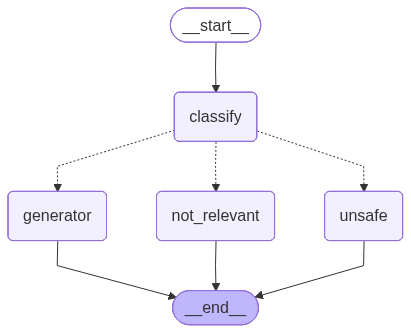

✓ Graph visualization displayed


In [14]:
# CELL_ID: 06_generation_v3_visualize_graph
# ============================================================================
# VISUALIZE GRAPH STRUCTURE
# ============================================================================

try:
    from IPython.display import Image, display
    graph_image = graph.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("✓ Graph visualization displayed")
except Exception as e:
    print(f"⚠ Visualization error: {e}")
    print("Graph structure:")
    print("  START → classify → [not_relevant | unsafe | generator] → END")


In [15]:
# CELL_ID: 06_generation_v3_gradio_interface
# ============================================================================
# GRADIO INTERFACE WITH STREAMING
# ============================================================================

def chat_interface(message, history):
    """
    Gradio chat interface function that processes messages through the graph.
    Supports streaming responses.
    """
    # Convert Gradio history to LangChain messages
    messages = []
    for user_msg, assistant_msg in history:
        if user_msg:
            messages.append(HumanMessage(content=user_msg))
        if assistant_msg:
            messages.append(AIMessage(content=assistant_msg))
    
    # Add current user message
    messages.append(HumanMessage(content=message))
    
    # Initialize state
    initial_state = {
        "messages": messages,
        "retrieved_chunks": [],
        "sources": [],
        "is_followup": False,
        "classification": None
    }
    
    # Stream response
    full_response = ""
    sources_text = ""
    
    try:
        # Stream with updates and messages
        for stream_type, chunk_data in graph.stream(
            initial_state,
            stream_mode=["updates", "messages"]
        ):
            # Handle updates (state changes)
            if stream_type == "updates":
                for node_name, state_update in chunk_data.items():
                    if node_name == "generator" and "messages" in state_update:
                        # Check for new AI message
                        new_messages = state_update.get("messages", [])
                        if new_messages:
                            last_msg = new_messages[-1]
                            if isinstance(last_msg, AIMessage) and last_msg.content:
                                full_response = last_msg.content
                    
                    # Extract sources if available
                    if "sources" in state_update:
                        sources = state_update["sources"]
                        if sources:
                            sources_text = "\n\n## Sources\n\n"
                            for i, source in enumerate(sources[:10], 1):
                                sources_text += f"{i}. [{source.title}]({source.url})\n"
            
            # Handle messages (streaming tokens)
            elif stream_type == "messages":
                message_chunk, metadata = chunk_data
                if hasattr(message_chunk, "content") and message_chunk.content:
                    # This is streaming - yield partial response
                    if isinstance(message_chunk, AIMessage):
                        full_response = message_chunk.content
                        yield full_response + sources_text
    
        # Final response
        if full_response:
            yield full_response + sources_text
        else:
            yield "No response generated."
        
    except Exception as e:
        error_msg = f"Error: {str(e)[:200]}"
        yield error_msg

# Create Gradio interface
def create_gradio_interface():
    """Create and return Gradio chat interface."""
    with gr.Blocks(title="Diabetes Knowledge Management Assistant", theme=gr.themes.Soft()) as demo:
        gr.Markdown("""
        # Diabetes Knowledge Management Assistant
        
        Ask questions about diabetes management, treatment, diagnosis, and related topics based on the Kenya National Clinical Guidelines.
        """)
        
        chatbot = gr.Chatbot(
            label="Conversation",
            height=600,
            show_copy_button=True
        )
        
        msg = gr.Textbox(
            label="Your Question",
            placeholder="Type your question here...",
            lines=2
        )
        
        with gr.Row():
            submit_btn = gr.Button("Submit", variant="primary")
            clear_btn = gr.Button("Clear Conversation")
        
        gr.Markdown("""
        ### Instructions
        - Ask questions about diabetes management, treatment, diagnosis, prevention, and related topics
        - The assistant will retrieve relevant information from the knowledge base
        - Responses include inline citations and a sources section
        - Follow-up questions can build on previous conversation
        """)
        
        # Event handlers
        def respond(message, history):
            # Process through graph
            response = ""
            for chunk in chat_interface(message, history):
                response = chunk
                yield history + [[message, chunk]]
        
        submit_btn.click(
            respond,
            inputs=[msg, chatbot],
            outputs=[chatbot]
        ).then(
            lambda: "",
            outputs=[msg]
        )
        
        msg.submit(
            respond,
            inputs=[msg, chatbot],
            outputs=[chatbot]
        ).then(
            lambda: "",
            outputs=[msg]
        )
        
        clear_btn.click(
            lambda: ([], ""),
            outputs=[chatbot, msg]
        )
    
    return demo

# Create interface
demo = create_gradio_interface()

print("✓ Gradio interface created")
print("\nTo launch the interface, run:")
print("  demo.launch(share=True)  # For public link")
print("  demo.launch()  # For local only")


✓ Gradio interface created

To launch the interface, run:
  demo.launch(share=True)  # For public link
  demo.launch()  # For local only


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31220\3015083700.py:89: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(


In [16]:
# CELL_ID: 07_generation_v2_initialize_chromadb
# ============================================================================
# INITIALIZE CHROMADB READER
# ============================================================================

print("=" * 60)
print("INITIALIZING CHROMADB READER")
print("=" * 60)

# Initialize Jina embedding function
jina_embedding_fn = JinaEmbeddingFunction()
print("✓ Jina embedding function ready")

# Initialize ChromaDB reader
chroma_reader = ChromaDBReader(
    chroma_db_path="./chroma_db",
    collection_name="diabetes_guidelines_v1",
    embedding_function=jina_embedding_fn
)
chroma_reader.initialize()

print("=" * 60)


INITIALIZING CHROMADB READER
✓ Jina embedding function ready
✓ ChromaDB client initialized: chroma_db
✓ Loaded collection: diabetes_guidelines_v1
  • Total chunks: 78


In [21]:
# CELL_ID: 06_generation_v3_launch_gradio
# ============================================================================
# LAUNCH GRADIO INTERFACE
# ============================================================================

# Launch the interface
# Uncomment the line below to launch
# demo.launch(share=True)  # Creates a public link
demo.close()

print("✓ Ready to launch Gradio interface")
print("Uncomment demo.launch() in the cell above to start the interface")


Closing server running on port: 7860
✓ Ready to launch Gradio interface
Uncomment demo.launch() in the cell above to start the interface
